In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import torch.optim as optim
import torchvision.models as models

# Duomenys ir paruošimas

In [ ]:
# parsisiunčiame Fashion MNIST duomenis ir apjungiam į vieną duomenų rinkinį

def download_dataset():

  trainset = datasets.FashionMNIST(
      root="data",
      train=True,
      download=True,
      transform=ToTensor()
  )

  testset = datasets.FashionMNIST(
      root="data",
      train=False,
      download=True,
      transform=ToTensor()
  )

  mnist_dataset = torch.utils.data.ConcatDataset([trainset, testset])

  return mnist_dataset

In [ ]:
# padaliname duomenis santykiu 60:20:20 į treniravimo, validavimo, testavimo duomenų rinkinius
# sukuriame dataloader kiekvienam duomenų rinkiniui nurodidami paketo dydį, subprocesų skaičių

def split_dataset_get_dataloaders(dataset, batch_size, num_workers):

  indices = list(range(len(dataset)))
  np.random.shuffle(indices)

  split_1 = int(0.6 * len(dataset))
  split_2 = int(0.8 * len(dataset))

  # sukurkite SubsetRandomSampler objektus
  train_sampler = SubsetRandomSampler(indices[:split_1])
  valid_sampler = SubsetRandomSampler(indices[split_1:split_2])
  test_sampler = SubsetRandomSampler(indices[split_2:])

  # Sukurkite DataLoader objektus naudodami sukurtus sampler'ius
  train_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers = num_workers, sampler=train_sampler)
  valid_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers = num_workers, sampler=valid_sampler)
  test_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers = num_workers, sampler=test_sampler)

  return train_dataloader, valid_dataloader, test_dataloader

# Treniravimas ir vertinimas

In [ ]:
# funkcija, kuri įvertina modelio veikimą, t.y. modelis, tuo metu nesimoko,
# modeliui paduodami testavimo/validavimo duomenys ir gaunami modelio spėjimai
# funkcija gražina tikras ir spėjamas duomenų klases

def evaluate(model, loader):
  model.eval()

  ground_truth = []
  predictions = []

  for data in loader:
    images = data[0].to(device)
    labels = data[1]

    with torch.no_grad():
      output = model(images)

    pred_label = torch.argmax(output, axis = 1)
    predictions = np.append(predictions, pred_label.cpu().detach())
    ground_truth = np.append(ground_truth, labels)

  return predictions, ground_truth

In [ ]:
# funkcija, kuri iškviečia modelio vertinimo funckiją evaluate(model, loader)
# ir, iš gautų tikrš ir spėjamų klasių, paskaičiuoja modelio veikimo tikslumą

def evaluate_while_training(model, loader):
  predictions, ground_truth = evaluate(model, loader)
  correct_predictions = np.sum(predictions == ground_truth)
  total_predictions = ground_truth.size
  accuracy = correct_predictions / total_predictions

  return accuracy

In [ ]:
# funkcija skirta apmokyti modelį per vieną epochą
# funkcijai paduodamas modelis, mokymosi duomenys, nuostolių f., optimizatorius
# modeliui duomenys yra paduodami paketais, kurių dydis nustatomas, kuriant dataloader
# funkcija gražina paskaičiuotą nuostolių funckijos vidurkį ir tikslumą mokymosi duomenis

def train_one_epoch(model, train_loader, loss_func, optimizer):
  loss_acum = []
  ground_truth = []
  predictions = []
  classes = 10

  model.train()

  for data in train_loader:
    images = data[0]
    labels = data[1]

    pred = model(images.to(device))
    loss = loss_func(pred, torch.nn.functional.one_hot(labels, classes).float().to(device))
    loss_acum = np.append(loss_acum, loss.item())

    loss.backward() #skaičiuojami gradientai
    optimizer.step() #modelio parametrai atnaujinami pagal apskaičiuotus gradientus
    optimizer.zero_grad() #nustatomi gradientai į nulį

    pred_label = torch.argmax(pred, axis = 1)
    predictions = np.append(predictions, pred_label.cpu().detach())
    ground_truth = np.append(ground_truth, labels)

  correct_predictions = np.sum(predictions == ground_truth)
  total_predictions = ground_truth.size
  accuracy = correct_predictions / total_predictions

  return np.mean(loss_acum), accuracy

In [ ]:
# funkcija, kuri skirta apmokyti modelį su duotu epochų skaičiumi
# funkcijai paduodamas modelis, nuostolių f., optimizatorius, mokymosi, validavimo duomenys, bei epochų skaičius
# funkcijos metu sukamas ciklas, kad pereiti visas epochas ir kviečiama funkcija, skirta apmokyti vieną epochą
# train_one_epoch(model, train_loader, loss_func, optimizer)
# funkcija gražina sukauptą visų epochų mokymosi ir validavimo klasifikavimo tikslumą, bei sukauptas nuostolių f. reikšmes

def train_all_epochs(model, loss_func, optimizer, train_loader, valid_loader, epoch_count = 15):

  start_time = datetime.now()

  train_accuracy_acum = []
  valid_accuracy_acum = []
  loss_avarage_acum = []

  for epoch in range(epoch_count):
    loss_avr, train_accuracy = train_one_epoch(model, train_loader, loss_func, optimizer)
    train_accuracy_acum.append(train_accuracy)

    valid_accuracy = evaluate_while_training(model, valid_loader)
    valid_accuracy_acum.append(valid_accuracy)
    loss_avarage_acum.append(loss_avr)

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss_avr}')
    print(f'  Training accuracy: {np.round(train_accuracy * 100, 2)}, Validation accuracy: {np.round(valid_accuracy * 100, 2)}')

  return train_accuracy_acum, valid_accuracy_acum, loss_avarage_acum

# Papildomos funkcijos

In [ ]:
# funkcija, skirta sukurti klasifikavimo matricai ir ją atspausdinti
# funkcijos argumentai: tikros ir modelio spėjamos klasių reikšmės

def create_and_print_matrix(ground_truth, predictions):
  # constant for classes
  classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

  # build confusion matrix
  matrix = confusion_matrix(ground_truth, predictions)
  data_frame = pd.DataFrame(matrix, index = [i for i in classes], columns = [i for i in classes])

  plt.figure(figsize = (8,6))
  plt.show()
  plt.tight_layout()
  sn.heatmap(data_frame, annot=True, cbar=None,fmt="d") # cmap="YlGnBu"

In [ ]:
# funkcija, kuri paskaičiuoja laiką [valandų]:minučių:sekundžių formatu

def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

## Grafikai architektūroms

In [ ]:
# funkcija, kuri nubraižo trijų modelių nuostolių funkciją

def plot_loss_models(a_acc, b_acc, c_acc):
  plt.figure(figsize=(5.5 ,5))
  plt.clf()
  plt.plot(range(1, epoch_count+1), a_acc)
  plt.plot(range(1, epoch_count+1), b_acc)
  plt.plot(range(1, epoch_count+1), c_acc)
  plt.ylim(0.0, 1.0)
  plt.title('Modelio nuostolių funkcija')
  plt.ylabel('Nuostolis')
  plt.xlabel('Epochos')
  plt.legend(['MyModel', 'AlexNet', 'LeNet'], loc='upper right')
  plt.show()

In [ ]:
def plot_acc_models(my_model_train_acc, alexnet_train_acc, lenet_train_acc, my_model_valid_acc, alexnet_valid_acc, lenet_valid_acc):
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epoch_count+1),my_model_train_acc)
  plt.plot(range(1, epoch_count+1),alexnet_train_acc)
  plt.plot(range(1, epoch_count+1),lenet_train_acc)
  plt.ylim(0.0, 1.0)
  plt.title('Modelio mokymo tikslumas')
  plt.ylabel('Mokymo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['MyModel', 'AlexNet', 'LeNet'], loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc)
  plt.plot(range(1, epoch_count+1), alexnet_valid_acc)
  plt.plot(range(1, epoch_count+1), lenet_valid_acc)
  plt.ylim(0.0, 1.0)
  plt.title('Modelio validavimo tikslumas')
  plt.ylabel('Validavimo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['MyModel', 'AlexNet', 'LeNet'], loc='lower right')

  plt.tight_layout()
  plt.show()

## Grafikai optimizatoriui

In [ ]:
def plot_acc_optim(my_model_train_acc, my_model_train_acc_sgd, my_model_valid_acc, my_model_valid_acc_sgd):
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epoch_count+1),my_model_train_acc)
  plt.plot(range(1, epoch_count+1),my_model_train_acc_sgd)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel mokymo tikslumas nuo optimizatoriaus')
  plt.ylabel('Mokymo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['Adam', 'SGD'], loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc_sgd)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel validavimo tikslumas nuo optimizatoriaus')
  plt.ylabel('Validavimo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['Adam', 'SGD'], loc='lower right')

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_loss_optim(a_acc, b_acc):
  plt.figure(figsize=(5.5 ,5))
  plt.clf()
  plt.plot(range(1, epoch_count+1), a_acc)
  plt.plot(range(1, epoch_count+1), b_acc)
  plt.title('MyModel nuostolių f. reikšmės nuo optimizatoriaus')
  plt.ylabel('Nuostolis')
  plt.xlabel('Epochos')
  plt.legend(['Adam', 'SGD'], loc='upper right')
  plt.show()

## Grafikai aktyvacijos funkcijai

In [ ]:
def plot_acc_activ(my_model_train_acc, my_model_train_acc_sig, my_model_valid_acc, my_model_valid_acc_sig):
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epoch_count+1),my_model_train_acc)
  plt.plot(range(1, epoch_count+1),my_model_train_acc_sig)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel mokymo tikslumas nuo aktyvacijos f.')
  plt.ylabel('Mokymo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['ReLu', 'Sigmoid'], loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc_sig)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel validavimo tikslumas nuo aktyvacijos f.')
  plt.ylabel('Validavimo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['ReLu', 'Sigmoid'], loc='lower right')

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_loss_activ(a_acc, b_acc):
  plt.figure(figsize=(5.5 ,5))
  plt.clf()
  plt.plot(range(1, epoch_count+1), a_acc)
  plt.plot(range(1, epoch_count+1), b_acc)
  plt.title('MyModel nuostolių f. reikšmės nuo aktyvacijos f.')
  plt.ylabel('Nuostolis')
  plt.xlabel('Epochos')
  plt.legend(['ReLu', 'Sigmoid'], loc='upper right')
  plt.show()

## Grafikai išmetimo sluoksniams

### Vienas, du išmetimo sluoksniai

In [ ]:
def plot_acc_drop(my_model_train_acc, my_model_train_acc_drop1, my_model_train_acc_drop2, my_model_valid_acc, my_model_valid_acc_drop1, my_model_valid_acc_drop2):
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epoch_count+1),my_model_train_acc)
  plt.plot(range(1, epoch_count+1),my_model_train_acc_drop1)
  plt.plot(range(1, epoch_count+1),my_model_train_acc_drop2)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel mokymo tikslumas nuo išmetimo sluoksnių')
  plt.ylabel('Mokymo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['0 dropout', '1 dropout', '2 dropout'], loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc_drop1)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc_drop2)
  plt.ylim(0.0, 1.0)
  plt.title('Modelio validavimo tikslumas')
  plt.title('MyModel validavimo tikslumas nuo išmetimo sluoksnių')
  plt.xlabel('Epochos')
  plt.legend(['0 dropout', '1 dropout', '2 dropout'], loc='lower right')

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_loss_drop(a_acc, b_acc, c_acc):
  plt.figure(figsize=(5.5 ,5))
  plt.clf()
  plt.plot(range(1, epoch_count+1), a_acc)
  plt.plot(range(1, epoch_count+1), b_acc)
  plt.plot(range(1, epoch_count+1), c_acc)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel nuostolių f. reikšmės nuo išmetimo sluoksnių')
  plt.ylabel('Nuostolis')
  plt.xlabel('Epochos')
  plt.legend(['0 dropout', '1 dropout', '2 dropout'], loc='upper right')
  plt.show()

### Vienas sluoksnis su skirtingomis tikimybėmis

In [ ]:
def plot_acc_drop_p(my_model_train_acc, my_model_train_acc_drop1, my_model_train_acc_drop2, my_model_valid_acc, my_model_valid_acc_drop1, my_model_valid_acc_drop2):
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epoch_count+1),my_model_train_acc)
  plt.plot(range(1, epoch_count+1),my_model_train_acc_drop1)
  plt.plot(range(1, epoch_count+1),my_model_train_acc_drop2)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel mokymo tikslumas nuo išmetimo sl. tikimybės')
  plt.ylabel('Mokymo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['0,2 dropout', '0,5 dropout', '0,8 dropout'], loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc_drop1)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc_drop2)
  plt.ylim(0.0, 1.0)
  plt.title('Modelio validavimo tikslumas')
  plt.title('MyModel validavimo tikslumas nuo išmetimo sl. tikimybės')
  plt.xlabel('Epochos')
  plt.legend(['0,2 dropout', '0,5 dropout', '0,8 dropout'], loc='lower right')

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_loss_drop_p(a_acc, b_acc, c_acc):
  plt.figure(figsize=(5.5 ,5))
  plt.clf()
  plt.plot(range(1, epoch_count+1), a_acc)
  plt.plot(range(1, epoch_count+1), b_acc)
  plt.plot(range(1, epoch_count+1), c_acc)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel nuostolių f. reikšmės nuo išmetimo sl. tikimybės')
  plt.ylabel('Nuostolis')
  plt.xlabel('Epochos')
  plt.legend(['0,2 dropout', '0,5 dropout', '0,8 dropout'], loc='upper right')
  plt.show()

## Grafikai paketų normalizavimui

In [ ]:
def plot_acc_norm(my_model_train_acc, my_model_train_acc_norm, my_model_valid_acc, my_model_valid_acc_norm):
  plt.figure(figsize=(10,5))
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epoch_count+1),my_model_train_acc)
  plt.plot(range(1, epoch_count+1),my_model_train_acc_norm)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel mokymo tikslumas nuo paketų normalizavimo')
  plt.ylabel('Mokymo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['Be normalizavimo', 'Su normalizavimu'], loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc)
  plt.plot(range(1, epoch_count+1), my_model_valid_acc_norm)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel validavimo tikslumas nuo paketų normalizavimo')
  plt.ylabel('Validavimo tikslumas')
  plt.xlabel('Epochos')
  plt.legend(['Be normalizavimo', 'Su normalizavimu'], loc='lower right')

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_loss_norm(a_acc, b_acc):
  plt.figure(figsize=(5.5 ,5))
  plt.clf()
  plt.plot(range(1, epoch_count+1), a_acc)
  plt.plot(range(1, epoch_count+1), b_acc)
  plt.ylim(0.0, 1.0)
  plt.title('MyModel nuostolių f. reikšmės nuo paketų normalizavimo')
  plt.ylabel('Nuostolis')
  plt.xlabel('Epochos')
  plt.legend(['Be normalizavimo', 'Su normalizavimu'], loc='upper right')
  plt.show()

# Modeliai

## Architektūroms lyginti

In [ ]:
# mano parašytas modelis, kuris naudojamas kaip bazė tyrimui keičiant hyperparametrus

class MyModel(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes

    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(64 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 224)
    self.fc2 = torch.nn.Linear(224, 128)
    self.fc3 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

In [ ]:
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
# modelis, skirtas architektūrų palyginimui, paimtas iš interneto platybių

class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# https://pytorch.org/hub/pytorch_vision_alexnet/
# architektūra https://pytorch.org/vision/main/_modules/torchvision/models/alexnet.html
# modelis, skirtas architektūrų palyginimui, paimtas iš interneto platybių

def create_alexnet_model(classes_count):
  alexnet = models.alexnet(weights=None)

  alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
  alexnet.classifier[6] = nn.Linear(4096, classes_count)

  return alexnet

## Kita aktyvacijos funkcija

In [ ]:
class MyModel_sigmoid(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes

    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(64 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 224)
    self.fc2 = torch.nn.Linear(224, 128)
    self.fc3 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.Sigmoid(),
        self.conv1_2,
        torch.nn.Sigmoid(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.Sigmoid(),
        self.conv2_2,
        torch.nn.Sigmoid(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.Sigmoid(),
        self.fc2,
        torch.nn.Sigmoid(),
        self.fc3
    )(x)
    return y

## Su išmetimo sluoksniais

In [ ]:
# su vienu išmetimo sluoksniu

class MyModel_drop1(torch.nn.Module):
  def __init__(self, in_shape, out_classes, prob):
    super().__init__()
    self.num_classes = out_classes

    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(64 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 224)
    self.dropout1 = nn.Dropout(prob)
    self.fc2 = torch.nn.Linear(224, 128)
    self.fc3 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        self.dropout1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

In [ ]:
# su dviem išmetimo sluoksniais

class MyModel_drop2(torch.nn.Module):
  def __init__(self, in_shape, out_classes, prob):
    super().__init__()
    self.num_classes = out_classes

    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.conv2_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.fc1 = torch.nn.Linear(64 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 224)
    self.dropout1 = nn.Dropout(prob)
    self.fc2 = torch.nn.Linear(224, 128)
    self.dropout2 = nn.Dropout(prob)
    self.fc3 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        self.dropout1,
        torch.nn.ReLU(),
        self.fc2,
        self.dropout2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

## Su paketų normalizavimu

In [ ]:
class MyModel_norm(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes

    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, (3, 3), padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(32, 32, (3, 3), padding = 'same')
    self.bn1 = torch.nn.BatchNorm2d(32)
    self.conv2_1 = torch.nn.Conv2d(32, 64, (3, 3), padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(64, 64, (3, 3), padding = 'same')
    self.bn2 = torch.nn.BatchNorm2d(64)
    self.fc1 = torch.nn.Linear(64 * (in_shape[1] // (2*2)) * (in_shape[2] // (2*2)), 224)
    self.fc2 = torch.nn.Linear(224, 128)
    self.fc3 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        self.bn1,
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        self.bn2,
        torch.nn.MaxPool2d((2, 2), (2, 2)),

        torch.nn.Flatten(),
        self.fc1,
        torch.nn.ReLU(),
        self.fc2,
        torch.nn.ReLU(),
        self.fc3
    )(x)
    return y

# GPU nustatymas

In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda:0


# Tyrimas

## Pasiruošimas

In [ ]:
# nustatome parametrus visoms trims architektūroms

batch_size = 64
num_workers = 2
lr = 1e-3
epoch_count = 15
classes_count = 10

In [ ]:
# parsisiunčiame duomenis
# sukuriame duomenų užkrovėjus mokymui, validavimui ir testavimui

mnist_dataset = download_dataset()
train_dataloader, valid_dataloader, test_dataloader = split_dataset_get_dataloaders(mnist_dataset, batch_size, num_workers)

100%|██████████| 26421880/26421880 [00:01<00:00, 17021263.71it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274721.23it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5067380.17it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15238021.87it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Trys skirtingos architektūros

In [ ]:
# apmokomas mano sukurtas modelis

my_model = MyModel(mnist_dataset[0][0].shape, classes_count).to(device)
print(f'Parameter count: {sum(p.numel() for p in my_model.parameters() if p.requires_grad):,}')

my_model_loss_func = torch.nn.CrossEntropyLoss()
my_model_optimizer = torch.optim.Adam(my_model.parameters(), lr = lr)

my_model_train_acc, my_model_valid_acc, my_model_loss_acum = train_all_epochs(my_model, my_model_loss_func, my_model_optimizer, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 797,770
Epoch: 0, Time: 9s, Training loss: 0.5428925934538268
  Training accuracy: 79.87, Validation accuracy: 87.16
Epoch: 1, Time: 21s, Training loss: 0.3134045718036467
  Training accuracy: 88.47, Validation accuracy: 88.88
Epoch: 2, Time: 32s, Training loss: 0.2583004349510964
  Training accuracy: 90.36, Validation accuracy: 90.5
Epoch: 3, Time: 43s, Training loss: 0.22795635532117145
  Training accuracy: 91.52, Validation accuracy: 90.93
Epoch: 4, Time: 54s, Training loss: 0.19972807441694915
  Training accuracy: 92.51, Validation accuracy: 91.72
Epoch: 5, Time: 1m4s, Training loss: 0.17338838235473705
  Training accuracy: 93.55, Validation accuracy: 91.79
Epoch: 6, Time: 1m15s, Training loss: 0.15036234599814569
  Training accuracy: 94.3, Validation accuracy: 91.97
Epoch: 7, Time: 1m27s, Training loss: 0.1283784589221307
  Training accuracy: 95.24, Validation accuracy: 92.4
Epoch: 8, Time: 1m37s, Training loss: 0.10830010969086892
  Training accuracy: 96.01, Vali

In [ ]:
# apmokomas alexnet modelis iš interneto

alexnet = create_alexnet_model(classes_count)
print(f'Parameter count: {sum(p.numel() for p in alexnet.parameters() if p.requires_grad):,}')

alexnet_loss_func = torch.nn.CrossEntropyLoss()
alexnet_optimizer = torch.optim.Adam(alexnet.parameters(), lr = lr)

alexnet_train_acc, alexnet_valid_acc, alexnet_loss_acum = train_all_epochs(alexnet.to(device), alexnet_loss_func, alexnet_optimizer, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 57,022,154
Epoch: 0, Time: 31s, Training loss: 0.80952451635532
  Training accuracy: 68.3, Validation accuracy: 81.89
Epoch: 1, Time: 59s, Training loss: 0.4592179170210067
  Training accuracy: 83.24, Validation accuracy: 84.39
Epoch: 2, Time: 1m26s, Training loss: 0.38609245405893894
  Training accuracy: 86.1, Validation accuracy: 87.24
Epoch: 3, Time: 1m54s, Training loss: 0.3516181950064736
  Training accuracy: 87.3, Validation accuracy: 88.21
Epoch: 4, Time: 2m22s, Training loss: 0.3311244262612029
  Training accuracy: 88.05, Validation accuracy: 88.55
Epoch: 5, Time: 2m50s, Training loss: 0.303710737491035
  Training accuracy: 88.89, Validation accuracy: 88.61
Epoch: 6, Time: 3m17s, Training loss: 0.30247316612682024
  Training accuracy: 89.06, Validation accuracy: 88.75
Epoch: 7, Time: 3m45s, Training loss: 0.2864735640551402
  Training accuracy: 89.56, Validation accuracy: 88.81
Epoch: 8, Time: 4m12s, Training loss: 0.26968231306183105
  Training accuracy: 90.07

In [ ]:
# apmokomas lenet modelis iš interneto

lenet = LeNet(classes_count).to(device)
print(f'Parameter count: {sum(p.numel() for p in lenet.parameters() if p.requires_grad):,}')

lenet_loss_func = torch.nn.CrossEntropyLoss()
lenet_optimizer = torch.optim.Adam(lenet.parameters(), lr = lr)

lenet_train_acc, lenet_valid_acc, lenet_loss_acum = train_all_epochs(lenet, lenet_loss_func, lenet_optimizer, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 44,426
Epoch: 0, Time: 9s, Training loss: 0.7776936856488296
  Training accuracy: 70.2, Validation accuracy: 77.91
Epoch: 1, Time: 18s, Training loss: 0.5004287468697564
  Training accuracy: 81.43, Validation accuracy: 82.92
Epoch: 2, Time: 28s, Training loss: 0.42073569622576873
  Training accuracy: 84.68, Validation accuracy: 85.48
Epoch: 3, Time: 37s, Training loss: 0.37305149662803117
  Training accuracy: 86.24, Validation accuracy: 85.81
Epoch: 4, Time: 47s, Training loss: 0.34669614447170194
  Training accuracy: 87.33, Validation accuracy: 87.46
Epoch: 5, Time: 56s, Training loss: 0.3210319399243983
  Training accuracy: 88.2, Validation accuracy: 88.33
Epoch: 6, Time: 1m5s, Training loss: 0.30323382588372744
  Training accuracy: 88.8, Validation accuracy: 88.61
Epoch: 7, Time: 1m15s, Training loss: 0.2855298821013449
  Training accuracy: 89.38, Validation accuracy: 88.11
Epoch: 8, Time: 1m25s, Training loss: 0.2726076406226855
  Training accuracy: 89.81, Validati

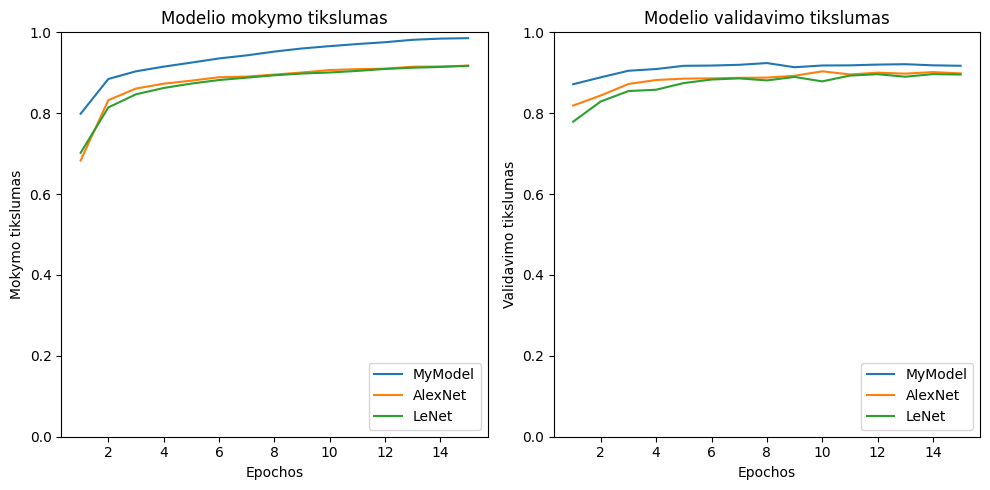

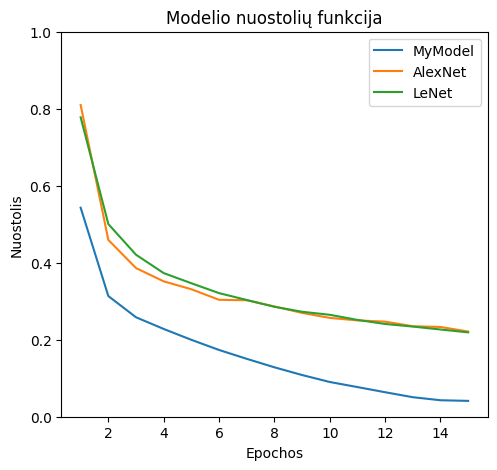

In [ ]:
# atspausdinami rezultatai

plot_acc_models(my_model_train_acc, alexnet_train_acc, lenet_train_acc, my_model_valid_acc, alexnet_valid_acc, lenet_valid_acc)
plot_loss_models(my_model_loss_acum, alexnet_loss_acum, lenet_loss_acum)

## Optimizatorius

In [ ]:
# apmokomas mano sukurtas modelis su SGD optimizatoriumi

my_model_sgd = MyModel(mnist_dataset[0][0].shape, classes_count).to(device)
print(f'Parameter count: {sum(p.numel() for p in my_model_sgd.parameters() if p.requires_grad):,}')

my_model_loss_func_sgd = torch.nn.CrossEntropyLoss()
my_model_optimizer_sgd = torch.optim.SGD(my_model_sgd.parameters(), lr=lr, momentum=0.9)

my_model_train_acc_sgd, my_model_valid_acc_sgd, my_model_loss_acum_sgd = train_all_epochs(my_model_sgd, my_model_loss_func_sgd, my_model_optimizer_sgd, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 797,770
Epoch: 0, Time: 9s, Training loss: 2.3024947425546167
  Training accuracy: 11.34, Validation accuracy: 17.13
Epoch: 1, Time: 20s, Training loss: 2.2894473569396787
  Training accuracy: 19.76, Validation accuracy: 38.11
Epoch: 2, Time: 31s, Training loss: 1.0406588271056136
  Training accuracy: 63.93, Validation accuracy: 73.11
Epoch: 3, Time: 42s, Training loss: 0.653596872154799
  Training accuracy: 75.42, Validation accuracy: 76.75
Epoch: 4, Time: 52s, Training loss: 0.5842026135965025
  Training accuracy: 78.01, Validation accuracy: 80.76
Epoch: 5, Time: 1m3s, Training loss: 0.5298377474149069
  Training accuracy: 80.31, Validation accuracy: 81.35
Epoch: 6, Time: 1m13s, Training loss: 0.489896675858142
  Training accuracy: 81.82, Validation accuracy: 82.45
Epoch: 7, Time: 1m24s, Training loss: 0.460515510546018
  Training accuracy: 82.94, Validation accuracy: 83.41
Epoch: 8, Time: 1m35s, Training loss: 0.43653025833076176
  Training accuracy: 83.86, Validati

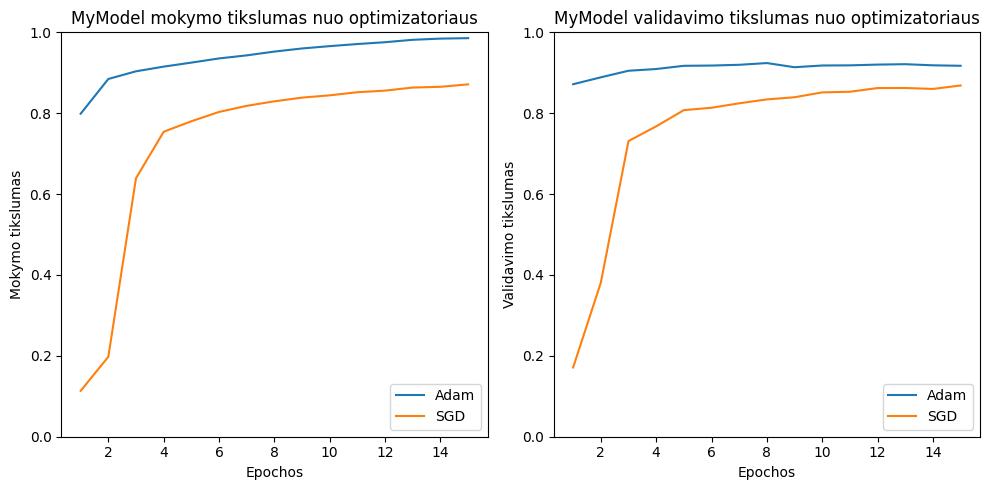

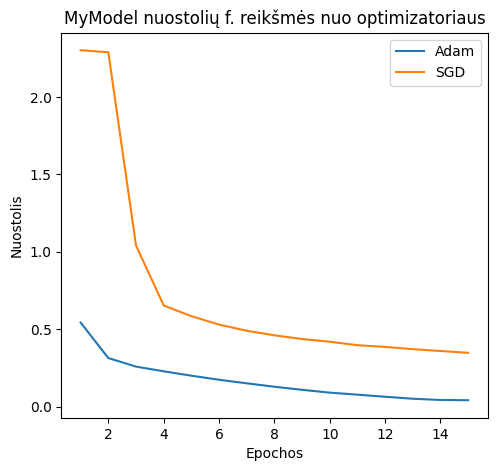

In [ ]:
plot_acc_optim(my_model_train_acc, my_model_train_acc_sgd, my_model_valid_acc, my_model_valid_acc_sgd)
plot_loss_optim(my_model_loss_acum, my_model_loss_acum_sgd)

## Aktyvacijos funkcija

In [ ]:
my_model_sig = MyModel_sigmoid(mnist_dataset[0][0].shape, classes_count).to(device)
print(f'Parameter count: {sum(p.numel() for p in my_model_sig.parameters() if p.requires_grad):,}')

my_model_loss_func_sig = torch.nn.CrossEntropyLoss()
my_model_optimizer_sig = torch.optim.Adam(my_model_sig.parameters(), lr = lr)

my_model_train_acc_sig, my_model_valid_acc_sig, my_model_loss_acum_sig = train_all_epochs(my_model_sig, my_model_loss_func_sig, my_model_optimizer_sig, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 797,770
Epoch: 0, Time: 11s, Training loss: 2.308556266026954
  Training accuracy: 9.92, Validation accuracy: 9.92
Epoch: 1, Time: 22s, Training loss: 2.3040289940536476
  Training accuracy: 9.89, Validation accuracy: 9.81
Epoch: 2, Time: 32s, Training loss: 2.3032820598538426
  Training accuracy: 9.87, Validation accuracy: 9.88
Epoch: 3, Time: 42s, Training loss: 2.3028735004059255
  Training accuracy: 9.78, Validation accuracy: 9.86
Epoch: 4, Time: 53s, Training loss: 2.3029513914291173
  Training accuracy: 10.1, Validation accuracy: 9.88
Epoch: 5, Time: 1m5s, Training loss: 1.7616759630280179
  Training accuracy: 30.16, Validation accuracy: 71.12
Epoch: 6, Time: 1m16s, Training loss: 0.5730881350543038
  Training accuracy: 78.49, Validation accuracy: 82.42
Epoch: 7, Time: 1m26s, Training loss: 0.41498528670411855
  Training accuracy: 84.78, Validation accuracy: 85.72
Epoch: 8, Time: 1m37s, Training loss: 0.35336851942121894
  Training accuracy: 87.0, Validation accu

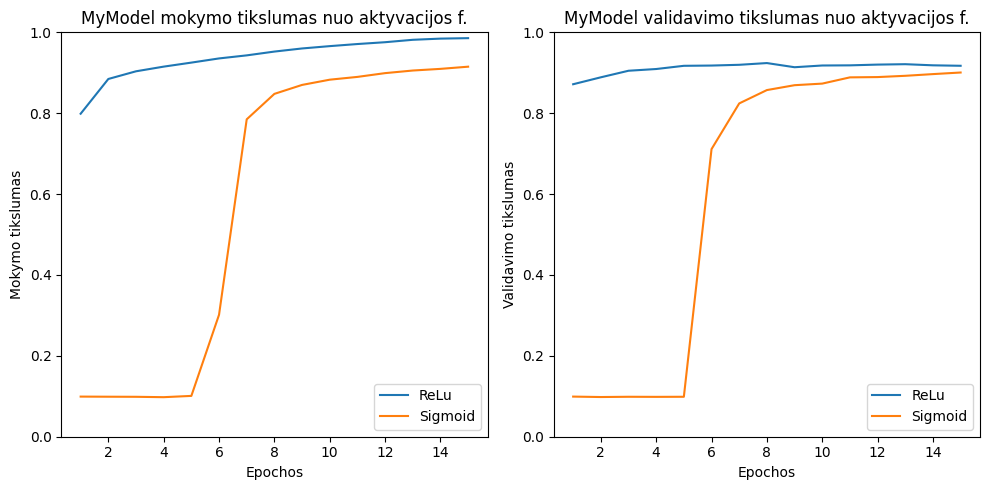

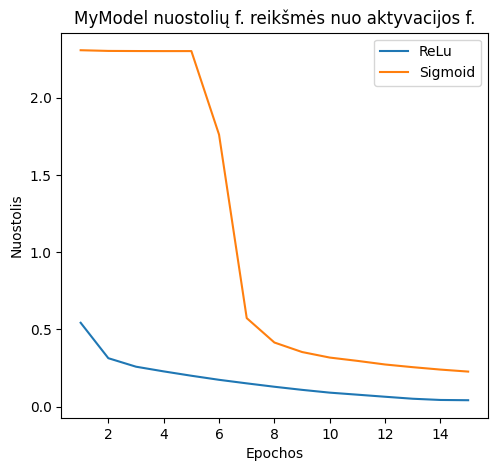

In [ ]:
plot_acc_activ(my_model_train_acc, my_model_train_acc_sig, my_model_valid_acc, my_model_valid_acc_sig)
plot_loss_activ(my_model_loss_acum, my_model_loss_acum_sig)

## Išmetimo sluoksniai

### Vienas ir du sluoksniai

In [ ]:
my_model_drop1 = MyModel_drop1(mnist_dataset[0][0].shape, classes_count, 0.5).to(device)
print(f'Parameter count: {sum(p.numel() for p in my_model_drop1.parameters() if p.requires_grad):,}')

my_model_loss_func_drop1 = torch.nn.CrossEntropyLoss()
my_model_optimizer_drop1 = torch.optim.Adam(my_model_drop1.parameters(), lr = lr)

my_model_train_acc_drop1, my_model_valid_acc_drop1, my_model_loss_acum_drop1 = train_all_epochs(my_model_drop1, my_model_loss_func_drop1, my_model_optimizer_drop1, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 797,770
Epoch: 0, Time: 10s, Training loss: 0.6287803320579877
  Training accuracy: 76.33, Validation accuracy: 85.81
Epoch: 1, Time: 22s, Training loss: 0.38773308211265634
  Training accuracy: 85.85, Validation accuracy: 88.2
Epoch: 2, Time: 36s, Training loss: 0.3250975577526441
  Training accuracy: 87.97, Validation accuracy: 89.85
Epoch: 3, Time: 49s, Training loss: 0.28763199175737764
  Training accuracy: 89.48, Validation accuracy: 90.44
Epoch: 4, Time: 1m1s, Training loss: 0.2616504565777209
  Training accuracy: 90.53, Validation accuracy: 90.69
Epoch: 5, Time: 1m12s, Training loss: 0.23853953383987717
  Training accuracy: 91.36, Validation accuracy: 91.04
Epoch: 6, Time: 1m23s, Training loss: 0.21684581195564212
  Training accuracy: 92.08, Validation accuracy: 91.55
Epoch: 7, Time: 1m34s, Training loss: 0.20052752908052737
  Training accuracy: 92.72, Validation accuracy: 92.24
Epoch: 8, Time: 1m46s, Training loss: 0.18292684426681455
  Training accuracy: 93.28

In [ ]:
my_model_drop2 = MyModel_drop2(mnist_dataset[0][0].shape, classes_count, 0.5).to(device)
print(f'Parameter count: {sum(p.numel() for p in my_model_drop2.parameters() if p.requires_grad):,}')

my_model_loss_func_drop2 = torch.nn.CrossEntropyLoss()
my_model_optimizer_drop2 = torch.optim.Adam(my_model_drop2.parameters(), lr = lr)

my_model_train_acc_drop2, my_model_valid_acc_drop2, my_model_loss_acum_drop2 = train_all_epochs(my_model_drop2, my_model_loss_func_drop2, my_model_optimizer_drop2, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 797,770
Epoch: 0, Time: 10s, Training loss: 0.7238070769306368
  Training accuracy: 73.21, Validation accuracy: 85.54
Epoch: 1, Time: 21s, Training loss: 0.41630258582407664
  Training accuracy: 85.16, Validation accuracy: 88.19
Epoch: 2, Time: 33s, Training loss: 0.350969230362088
  Training accuracy: 87.47, Validation accuracy: 89.63
Epoch: 3, Time: 45s, Training loss: 0.31226846375013595
  Training accuracy: 89.08, Validation accuracy: 90.39
Epoch: 4, Time: 56s, Training loss: 0.2856860181977306
  Training accuracy: 89.88, Validation accuracy: 90.79
Epoch: 5, Time: 1m7s, Training loss: 0.26085785698128616
  Training accuracy: 90.84, Validation accuracy: 91.09
Epoch: 6, Time: 1m18s, Training loss: 0.2449616563692122
  Training accuracy: 91.23, Validation accuracy: 91.16
Epoch: 7, Time: 1m29s, Training loss: 0.23100794629509955
  Training accuracy: 91.82, Validation accuracy: 91.94
Epoch: 8, Time: 1m41s, Training loss: 0.21259915215194317
  Training accuracy: 92.49, V

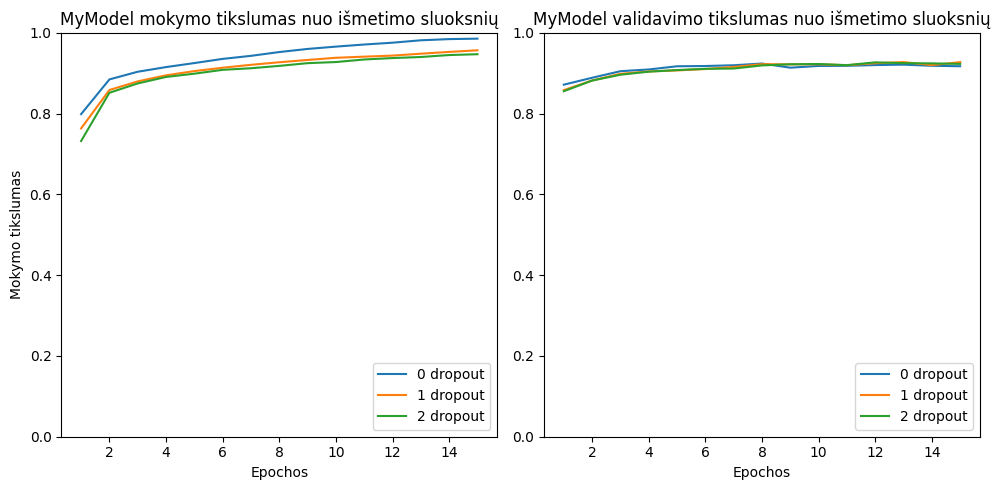

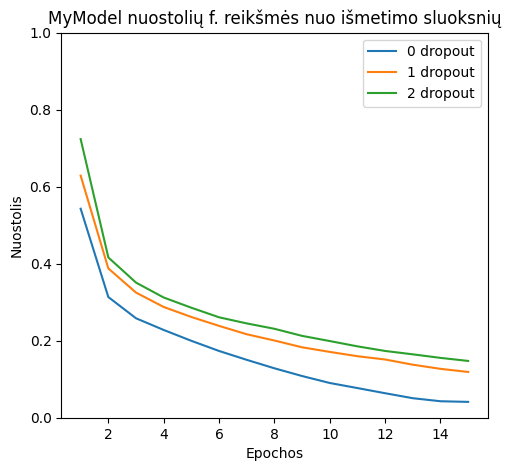

In [ ]:
plot_acc_drop(my_model_train_acc, my_model_train_acc_drop1, my_model_train_acc_drop2, my_model_valid_acc, my_model_valid_acc_drop1, my_model_valid_acc_drop2)
plot_loss_drop(my_model_loss_acum, my_model_loss_acum_drop1, my_model_loss_acum_drop2)

### Skirtingos vieno išmetimo sluoksnio tikimybės

In [ ]:
my_model_drop1_2 = MyModel_drop1(mnist_dataset[0][0].shape, classes_count, 0.2).to(device)
print(f'Parameter count: {sum(p.numel() for p in my_model_drop1_2.parameters() if p.requires_grad):,}')

my_model_loss_func_drop1_2 = torch.nn.CrossEntropyLoss()
my_model_optimizer_drop1_2 = torch.optim.Adam(my_model_drop1_2.parameters(), lr = lr)

my_model_train_acc_drop1_2, my_model_valid_acc_drop1_2, my_model_loss_acum_drop1_2 = train_all_epochs(my_model_drop1_2, my_model_loss_func_drop1_2, my_model_optimizer_drop1_2, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 797,770
Epoch: 0, Time: 13s, Training loss: 0.5738596594587672
  Training accuracy: 78.78, Validation accuracy: 86.86
Epoch: 1, Time: 25s, Training loss: 0.335819725349795
  Training accuracy: 87.64, Validation accuracy: 88.28
Epoch: 2, Time: 35s, Training loss: 0.2789503949123068
  Training accuracy: 89.61, Validation accuracy: 90.14
Epoch: 3, Time: 46s, Training loss: 0.24643519584265292
  Training accuracy: 90.79, Validation accuracy: 90.58
Epoch: 4, Time: 57s, Training loss: 0.218686189292682
  Training accuracy: 92.02, Validation accuracy: 91.19
Epoch: 5, Time: 1m9s, Training loss: 0.19472675552220287
  Training accuracy: 92.76, Validation accuracy: 92.16
Epoch: 6, Time: 1m21s, Training loss: 0.17438857823814433
  Training accuracy: 93.59, Validation accuracy: 92.05
Epoch: 7, Time: 1m41s, Training loss: 0.15551853834267257
  Training accuracy: 94.19, Validation accuracy: 92.38
Epoch: 8, Time: 1m52s, Training loss: 0.13679365575585736
  Training accuracy: 94.85, Va

In [ ]:
my_model_drop1_8 = MyModel_drop1(mnist_dataset[0][0].shape, classes_count, 0.8).to(device)
print(f'Parameter count: {sum(p.numel() for p in my_model_drop1_8.parameters() if p.requires_grad):,}')

my_model_loss_func_drop1_8 = torch.nn.CrossEntropyLoss()
my_model_optimizer_drop1_8 = torch.optim.Adam(my_model_drop1_8.parameters(), lr = lr)

my_model_train_acc_drop1_8, my_model_valid_acc_drop1_8, my_model_loss_acum_drop1_8 = train_all_epochs(my_model_drop1_8, my_model_loss_func_drop1_8, my_model_optimizer_drop1_8, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 797,770
Epoch: 0, Time: 17s, Training loss: 0.9041180436469648
  Training accuracy: 65.18, Validation accuracy: 82.22
Epoch: 1, Time: 31s, Training loss: 0.5819978842815127
  Training accuracy: 77.97, Validation accuracy: 86.14
Epoch: 2, Time: 47s, Training loss: 0.500705286043964
  Training accuracy: 81.23, Validation accuracy: 87.55
Epoch: 3, Time: 1m2s, Training loss: 0.44554469418035797
  Training accuracy: 83.59, Validation accuracy: 85.33
Epoch: 4, Time: 1m17s, Training loss: 0.40587871429854877
  Training accuracy: 84.92, Validation accuracy: 88.53
Epoch: 5, Time: 1m30s, Training loss: 0.3740114136124129
  Training accuracy: 86.23, Validation accuracy: 89.99
Epoch: 6, Time: 1m42s, Training loss: 0.34861795260617723
  Training accuracy: 87.29, Validation accuracy: 89.6
Epoch: 7, Time: 1m53s, Training loss: 0.32721732064650666
  Training accuracy: 88.19, Validation accuracy: 90.68
Epoch: 8, Time: 2m11s, Training loss: 0.3076078454358574
  Training accuracy: 89.01,

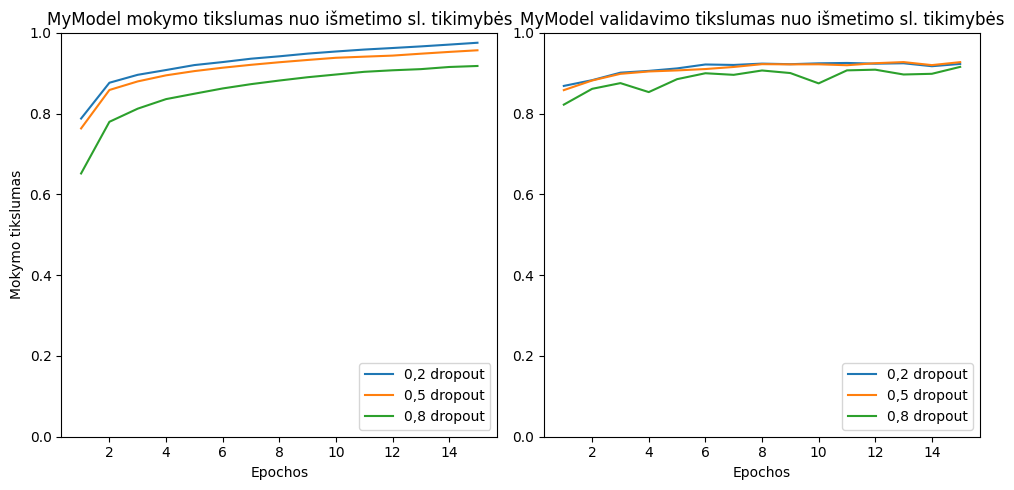

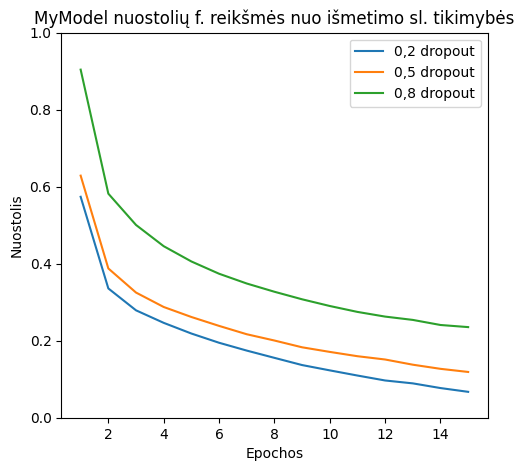

In [ ]:
plot_acc_drop_p(my_model_train_acc_drop1_2, my_model_train_acc_drop1, my_model_train_acc_drop1_8, my_model_valid_acc_drop1_2, my_model_valid_acc_drop1, my_model_valid_acc_drop1_8)
plot_loss_drop_p(my_model_loss_acum_drop1_2, my_model_loss_acum_drop1, my_model_loss_acum_drop1_8)

## Paketų normalizavimas

In [ ]:
my_model_norm = MyModel_norm(mnist_dataset[0][0].shape, classes_count).to(device)
print(f'Parameter count: {sum(p.numel() for p in my_model_norm.parameters() if p.requires_grad):,}')

my_model_loss_func_norm = torch.nn.CrossEntropyLoss()
my_model_optimizer_norm = torch.optim.Adam(my_model_norm.parameters(), lr = lr)

my_model_train_acc_norm, my_model_valid_acc_norm, my_model_loss_acum_norm = train_all_epochs(my_model_norm, my_model_loss_func_norm, my_model_optimizer_norm, train_dataloader, valid_dataloader, epoch_count = epoch_count)

Parameter count: 797,962
Epoch: 0, Time: 12s, Training loss: 0.36146317039087666
  Training accuracy: 86.81, Validation accuracy: 89.71
Epoch: 1, Time: 22s, Training loss: 0.2315588407105053
  Training accuracy: 91.55, Validation accuracy: 91.13
Epoch: 2, Time: 34s, Training loss: 0.1868790695911537
  Training accuracy: 93.14, Validation accuracy: 91.41
Epoch: 3, Time: 45s, Training loss: 0.15345147369454984
  Training accuracy: 94.31, Validation accuracy: 90.88
Epoch: 4, Time: 56s, Training loss: 0.12599217649577596
  Training accuracy: 95.35, Validation accuracy: 91.8
Epoch: 5, Time: 1m7s, Training loss: 0.10467805350241868
  Training accuracy: 96.19, Validation accuracy: 92.91
Epoch: 6, Time: 1m18s, Training loss: 0.08382234069599545
  Training accuracy: 96.87, Validation accuracy: 92.06
Epoch: 7, Time: 1m29s, Training loss: 0.07038693068459732
  Training accuracy: 97.44, Validation accuracy: 92.41
Epoch: 8, Time: 1m41s, Training loss: 0.05808560436597176
  Training accuracy: 97.91,

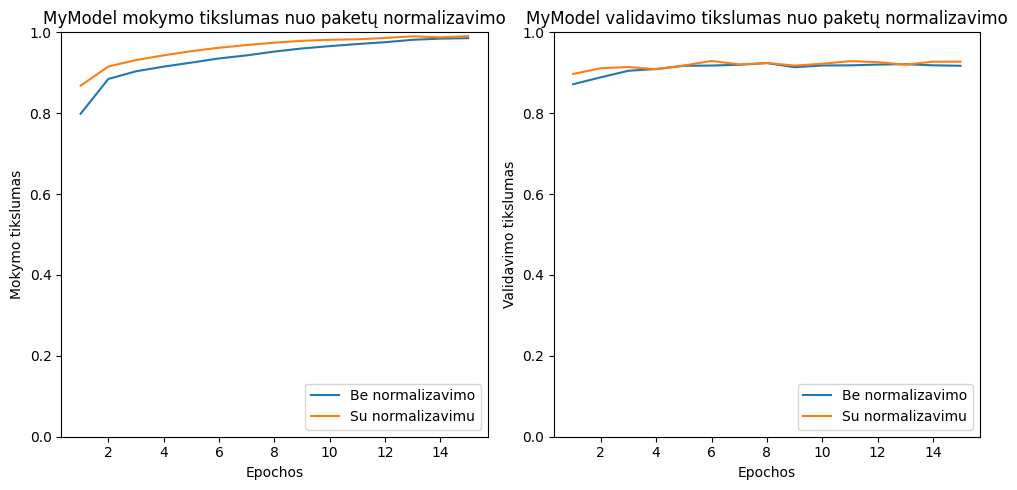

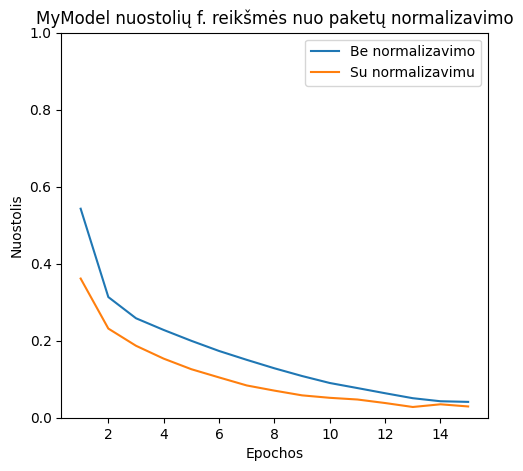

In [ ]:
plot_acc_norm(my_model_train_acc, my_model_train_acc_norm, my_model_valid_acc, my_model_valid_acc_norm)
plot_loss_norm(my_model_loss_acum, my_model_loss_acum_norm)

## Geriausias modelis ir testavimo rezultatai

In [ ]:
best_model = MyModel_norm(mnist_dataset[0][0].shape, classes_count).to(device)
print(f'Parameter count: {sum(p.numel() for p in best_model.parameters() if p.requires_grad):,}')

best_model_loss_func = torch.nn.CrossEntropyLoss()
best_model_optimizer = torch.optim.Adam(best_model.parameters(), lr = lr)

best_model_train_acc, best_model_valid_acc, best_model_loss_acum = train_all_epochs(best_model, best_model_loss_func, best_model_optimizer, train_dataloader, valid_dataloader, epoch_count = 11)

Parameter count: 797,962
Epoch: 0, Time: 17s, Training loss: 0.3743800235348024
  Training accuracy: 86.29, Validation accuracy: 89.51
Epoch: 1, Time: 29s, Training loss: 0.24842937343967922
  Training accuracy: 90.8, Validation accuracy: 90.33
Epoch: 2, Time: 45s, Training loss: 0.19890317818096057
  Training accuracy: 92.64, Validation accuracy: 92.12
Epoch: 3, Time: 1m0s, Training loss: 0.1622244518029091
  Training accuracy: 93.9, Validation accuracy: 91.79
Epoch: 4, Time: 1m11s, Training loss: 0.13054421536420305
  Training accuracy: 95.13, Validation accuracy: 92.61
Epoch: 5, Time: 1m21s, Training loss: 0.10777361967559773
  Training accuracy: 95.88, Validation accuracy: 92.27
Epoch: 6, Time: 1m33s, Training loss: 0.09185924175332898
  Training accuracy: 96.51, Validation accuracy: 91.66
Epoch: 7, Time: 1m57s, Training loss: 0.07139786546468689
  Training accuracy: 97.31, Validation accuracy: 92.27
Epoch: 8, Time: 2m11s, Training loss: 0.059159586482852855
  Training accuracy: 97

In [ ]:
predictions, ground_truth = evaluate(best_model, test_dataloader)

correct_predictions = np.sum(predictions == ground_truth)
total_predictions = ground_truth.size
accuracy = correct_predictions / total_predictions

In [ ]:
accuracy

0.9219285714285714

<Figure size 800x600 with 0 Axes>

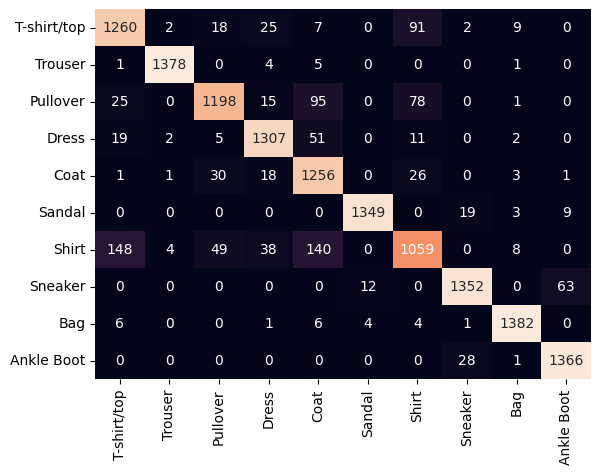

In [ ]:
create_and_print_matrix(ground_truth, predictions)

In [ ]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

for i in range(70, 100):
  print(i+1-70, '&', classes[int(ground_truth[i])], '&', classes[int(predictions[i])], ' \\\ \hline')

1 & Dress & Dress  \\ \hline
2 & Coat & Coat  \\ \hline
3 & Shirt & Shirt  \\ \hline
4 & Pullover & Shirt  \\ \hline
5 & Pullover & Pullover  \\ \hline
6 & Coat & Coat  \\ \hline
7 & Bag & Bag  \\ \hline
8 & Shirt & Shirt  \\ \hline
9 & Shirt & Coat  \\ \hline
10 & Sandal & Sandal  \\ \hline
11 & Shirt & T-shirt/top  \\ \hline
12 & Pullover & Pullover  \\ \hline
13 & Bag & Bag  \\ \hline
14 & Shirt & Coat  \\ \hline
15 & Sandal & Sandal  \\ \hline
16 & Dress & Dress  \\ \hline
17 & T-shirt/top & Shirt  \\ \hline
18 & Ankle Boot & Ankle Boot  \\ \hline
19 & Shirt & T-shirt/top  \\ \hline
20 & Trouser & Trouser  \\ \hline
21 & Trouser & Trouser  \\ \hline
22 & Dress & Dress  \\ \hline
23 & Sandal & Sandal  \\ \hline
24 & Sneaker & Ankle Boot  \\ \hline
25 & Shirt & Shirt  \\ \hline
26 & Bag & Coat  \\ \hline
27 & Ankle Boot & Ankle Boot  \\ \hline
28 & Coat & Coat  \\ \hline
29 & Sandal & Sandal  \\ \hline
30 & Trouser & Trouser  \\ \hline
